# Titanic classification

In [1]:
import numpy as np
import pandas as pd
import math
import ML_functions as ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

df = pd.read_csv(r"C:\Users\marco\Downloads\Titanic.csv")
print(df.head())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

  Parch            Ticket     Fare Cabin Embarked  
0     0         A/5 21171     7.25     S      NaN  
1     0          PC 17599  71.2833   C85        C  
2     0  STON/O2. 3101282    7.925     S      NaN  
3     0            113803     53.1  C123        S  
4     0            373450     8.05     S      NaN  
<class '

## Database Description

In [2]:
df.describe(include='object')

,Name,Sex,Parch,Ticket,Fare,Cabin,Embarked
count,1309,1309,1309,1309,1309,1068,270
unique,1307,2,230,818,282,177,3
top,"Connolly, Miss. Kate",male,0,7.75,S,S,S
freq,2,843,768,35,118,641,155


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.377387,2.294882,23.974538,0.450726
std,378.020061,0.484918,0.837836,17.471656,0.925378
min,1.000000,0.000000,1.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,8.000000,0.000000
50%,655.000000,0.000000,3.000000,24.000000,0.000000
75%,982.000000,1.000000,3.000000,35.000000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,9.000000


In [4]:
null_count = df.isnull().sum()
print("\nNull Count:")
print(null_count)


Null Count:
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           241
Embarked       1039
dtype: int64


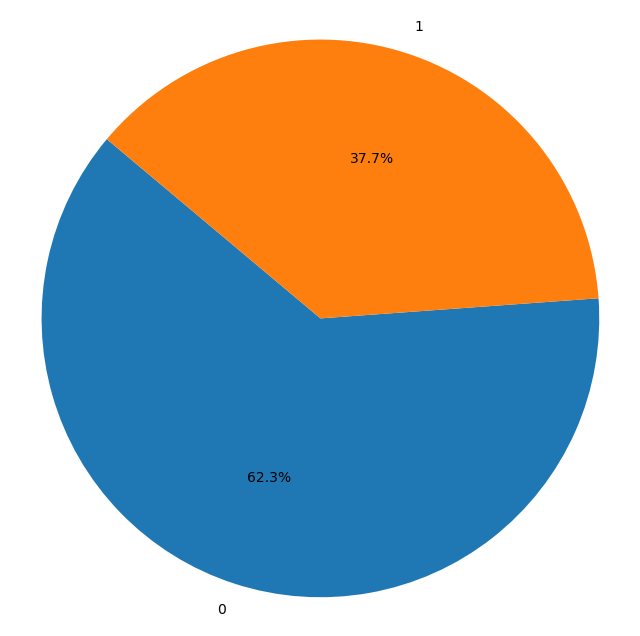

In [5]:
# Count the occurrences of each patient type
target_counts = df['Survived'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### Correlated variables to target attribute

In [6]:

def perform_chi_square_test(data, attribute, target):
    contingency_table = pd.crosstab(data[attribute], data[target])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

def chi_square_test_all_categorical(data, target):
    categorical_attributes = data.select_dtypes(include=['object']).columns
    results = []

    for attribute in categorical_attributes:
        chi2, p = perform_chi_square_test(data, attribute, target)
        results.append({'Attribute': attribute, 'Chi-Square': chi2, 'p-value': p})

    return pd.DataFrame(results)



In [7]:

chi_square_results = chi_square_test_all_categorical(df, 'Survived')
print(chi_square_results)


  Attribute   Chi-Square        p-value
0      Name  1309.000000   4.714215e-01
1       Sex   617.313352  2.871410e-136
2     Parch   248.350462   1.811872e-01
3    Ticket   923.833960   5.353831e-03
4      Fare   482.362032   8.075180e-13
5     Cabin   264.140900   1.902642e-05
6  Embarked     0.070129   9.655431e-01


"Sex," "Fare," and "Ticket" appear to be strongly associated with the target variable.
"Cabin" also shows a significant association, but it might be less strong than "Sex," "Fare," and "Ticket."
"Name," "Parch," and "Embarked" do not seem to have a significant association with the target variable so they can be dropped from the database.

### Preprocessing of the database

Drop unecessary columns for classification

In [8]:
df = df.drop(columns=["Name","PassengerId","Parch","Embarked"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Ticket    1309 non-null   object 
 6   Fare      1309 non-null   object 
 7   Cabin     1068 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 81.9+ KB
None


Do data imputation of the attribute "cabin" by using the mode to fill the na

In [9]:
mode_value = df["Cabin"].mode()[0]  # Get the mode of the column
df["Cabin"].fillna(mode_value, inplace=True)
df.describe(include='object')

,Sex,Ticket,Fare,Cabin
count,1309,1309,1309,1309
unique,2,818,282,177
top,male,7.75,S,S
freq,843,35,118,882


Balance the database using SMOTE

In [10]:
# Specify the categorical features using their column indices
categorical_features = [1, 4, 5,6]  # indices of the categorical columns

# Initialize SMOTENC with the desired k-value and ratio
#0.5 ratio means a 50/50 distribution of the target attribute
smote = SMOTENC(sampling_strategy=0.7, categorical_features=categorical_features, k_neighbors=5)

# Perform SMOTE
X_resampled, y_resampled = smote.fit_resample(df.drop('Survived', axis=1), df['Survived'])

# Create a new DataFrame with the resampled data
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


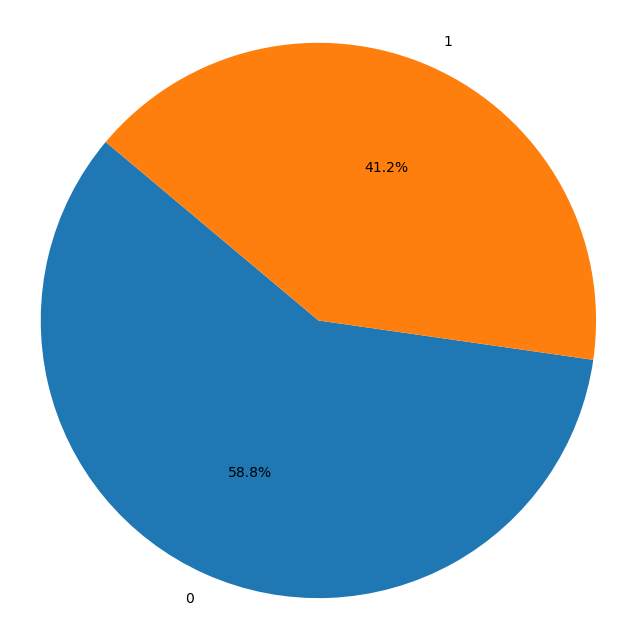

In [11]:
# Count the occurrences of each patient type
target_counts = resampled_df['Survived'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Encode categorical variables to numerical

In [12]:
df_encoded= ML.one_hot_encode_categorical(resampled_df)
print(df_encoded.info())
print(df_encoded.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Columns: 1283 entries, Pclass to Cabin_T
dtypes: int64(1283)
memory usage: 13.6 MB
None
(1385, 1283)


In [13]:
df_normalized= ML.normalize_minmax(df_encoded)
print(df_normalized.head())

   Pclass    Age     SibSp  Survived  Sex_female  Sex_male  Ticket_0  \
0     1.0 -0.450 -0.777778      -1.0        -1.0       1.0      -1.0   
1    -1.0 -0.050 -0.777778       1.0         1.0      -1.0      -1.0   
2     1.0 -0.350 -1.000000       1.0         1.0      -1.0      -1.0   
3    -1.0 -0.125 -0.777778       1.0         1.0      -1.0      -1.0   
4     1.0 -0.125 -1.000000      -1.0        -1.0       1.0      -1.0   

   Ticket_10.7083  Ticket_110.8833  Ticket_110152  ...  Cabin_F E57  \
0            -1.0             -1.0           -1.0  ...         -1.0   
1            -1.0             -1.0           -1.0  ...         -1.0   
2            -1.0             -1.0           -1.0  ...         -1.0   
3            -1.0             -1.0           -1.0  ...         -1.0   
4            -1.0             -1.0           -1.0  ...         -1.0   

   Cabin_F G63  Cabin_F G73  Cabin_F2  Cabin_F33  Cabin_F4  Cabin_G6  Cabin_Q  \
0         -1.0         -1.0      -1.0       -1.0      -1.0 

# KNN classification

In [14]:
def KNN(x_train,y_train,x_test,y_test):
    """
    Performs KNN algorithm to classify a DataFrame.

    Returns:
        Elbow method results
        Confusion matrix of test classification with optimal k
    """
     # Calculate the number of unique values in y_train to determine k_values
    unique_values_count = len(np.unique(y_train))
    
    # Create an array of k values that are not multiples of the unique_values_count
    k_values = [k for k in range(1, 31) if k % unique_values_count != 0]

    # Initialize arrays to store accuracy and confusion matrix
    accuracy_scores = []
    confusion_matrices = []

    for k in k_values:
        predictions = []

        for test_point in x_test.values:
            distances = []

            # Calculate Euclidean distance between the test point and all training points
            for train_point in x_train.values:
                distance = np.linalg.norm(test_point - train_point)
                distances.append(distance)

            # Get indices of k-nearest neighbors
            k_indices = np.argsort(distances)[:k]

            # Get labels of k-nearest neighbors
            k_nearest_labels = [y_train.iloc[i] for i in k_indices]

            # Predict the class based on majority vote
            prediction = max(set(k_nearest_labels), key=k_nearest_labels.count)
            predictions.append(prediction)

        correct = sum(1 for true, pred in zip(y_test, predictions) if true == pred)
        accuracy = correct / len(y_test)
        accuracy_scores.append(accuracy)

        # Calculate confusion matrix and store it
        confusion = confusion_matrix(y_test, predictions)
        confusion_matrices.append(confusion)

    # Find the index of the highest accuracy
    best_k_index = np.argmax(accuracy_scores)
    best_k = k_values[best_k_index]
    best_accuracy = accuracy_scores[best_k_index]

    # Print the best k value and its corresponding confusion matrix
    print(f'Best k value: {best_k}')
    print(f'Maximum accuracy: {best_accuracy}')

    # Plot the accuracy results vs. k values (elbow method)
    plt.plot(k_values, accuracy_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('k-NN Accuracy vs. k Values (Elbow Method)')
    plt.grid(True)
    plt.show()

    # Create a prettier confusion matrix with labeled axes
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices[best_k_index], annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Best k')
    plt.show()


In [15]:
# Splitting the DataFrame into 80% training and 20% testing
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)
y_train=train_df["Survived"]
y_test=test_df["Survived"]
x_train= train_df.drop(columns=["Survived"])
x_test= test_df.drop(columns=["Survived"])

Best k value: 15
Maximum accuracy: 0.855595667870036


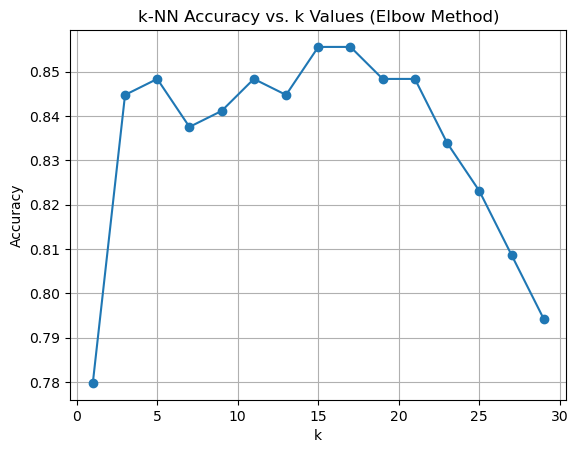

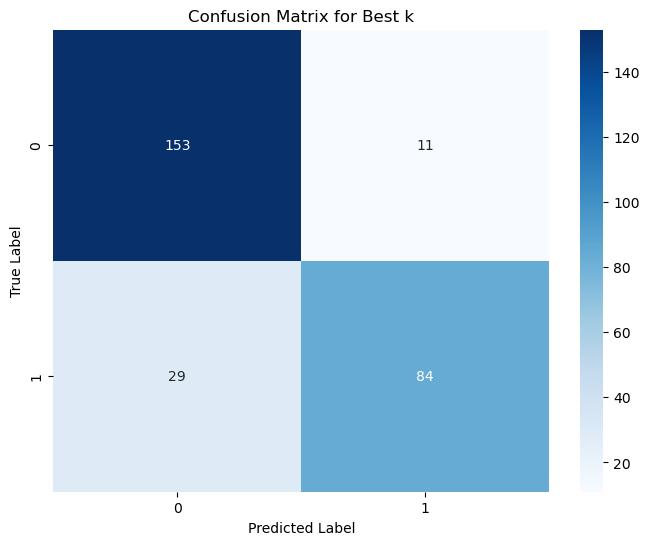

In [16]:
KNN(x_train,y_train,x_test,y_test)

In [17]:
sklearn_knn = KNeighborsClassifier(n_neighbors=29)
sklearn_knn.fit(x_train, y_train)
sklearn_predictions = sklearn_knn.predict(x_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
sklearn_confusion_matrix = confusion_matrix(y_test, sklearn_predictions)
print(sklearn_confusion_matrix)

[[150  14]
 [ 46  67]]


C:\Users\marco\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [18]:
print(f'Custom KNN Accuracy: 0.67')
print(f'Scikit-learn KNN Accuracy: {sklearn_accuracy}')

Custom KNN Accuracy: 0.67
Scikit-learn KNN Accuracy: 0.7833935018050542
